## Liveability index

#### This code explores the data further and develops a "liveability index" that shows how great a place will be in the future with regards to climate change

In [19]:
# import reqs
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime, statsmodels, warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
warnings.simplefilter("ignore")
from math import sqrt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import ipywidgets as widgets

In [17]:
# import cleaned data (will be replaced with sql commands once downstream analysis portion has been completed)
# this needs to communicate and pull the data from the SQL server
num_heating_days_state = pd.read_csv('processed_data/num_heating_days_state.csv')
num_cooling_days_state = pd.read_csv('processed_data/num_cooling_days_state.csv')
preciptation_state = pd.read_csv('processed_data/preciptation_state.csv')
temperature_avg_state = pd.read_csv('processed_data/temperature_avg_state.csv')
temperature_max_state = pd.read_csv('processed_data/temperature_max_state.csv')
temperature_min_state = pd.read_csv('processed_data/temperature_min_state.csv')

# make the data frame
num_heating_days_state = pd.DataFrame(num_heating_days_state)
num_cooling_days_state = pd.DataFrame(num_cooling_days_state)
preciptation_state = pd.DataFrame(preciptation_state)
temperature_avg_state = pd.DataFrame(temperature_avg_state)
temperature_max_state = pd.DataFrame(temperature_max_state)
temperature_min_state = pd.DataFrame(temperature_min_state)

# list the column names to be working with
print(num_heating_days_state.columns)
print(len(num_heating_days_state))

Index(['col_num', 'ClimDivCode_x', 'fips_code_start', 'weather_data_type',
       'year', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept',
       'oct', 'nov', 'dec', 'NCDC_FIPS_ID', 'ClimDivCode_y', 'ActualDivCode',
       'StateName', 'FIPS code', 'name', 'State Code', 'CLIMDIV_ID'],
      dtype='object')
399771


In [4]:
num_heating_days_state.head()

col_num  ClimDivCode_x  fips_code_start  weather_data_type  year  jan  feb  \
0        0              1                1                 25  1895  661  750   
1        1              1                1                 25  1896  651  453   
2        2              1                1                 25  1897  670  368   
3        3              1                1                 25  1898  485  510   
4        4              1                1                 25  1899  641  658   

   mar  apr  may  ...    nov    dec  NCDC_FIPS_ID  ClimDivCode_y  \
0  314   87   15  ...  327.0  612.0          1001            1.0   
1  356   22    0  ...  232.0  553.0          1001            1.0   
2  180  105   18  ...  312.0  526.0          1001            1.0   
3  205  178    0  ...  445.0  645.0          1001            1.0   
4  286  117    0  ...  291.0  609.0          1001            1.0   

   ActualDivCode  StateName  FIPS code            name  State Code  CLIMDIV_ID  
0            1.0    Alabama       1001  Autauga County         1.0         103  
1            1.0    Alabama       1001  Autauga County         1.0         103  
2            1.0    Alabama       1001  Autauga County         1.0         103  
3            1.0    Alabama       1001  Autauga County         1.0         103  
4            1.0    Alabama       1001  Autauga County         1.0         103  

[5 rows x 25 columns]

In [5]:
# select the state and county you want by entering its name, matches with the county name and state
def select_data(df, val1, val2):
    """Helper function to match the State Name and County"""
    result = df[(df["StateName"] == val1) & (df["name"].str.contains(val2 + " County"))]
    if result.empty:
        return "Error no matching data was found"
    else:
        return result

### To run the stats we are going to be looking at my home county where I grew up Forsyth County Georgia

In [6]:
# select subset of data to begin building the model, should be cleared later when functionality is built out
# dont forget to not include NaN values in the analysis, these should not be included in the count
heat = select_data(num_heating_days_state, "Georgia", "Forsyth")
cool = select_data(num_cooling_days_state, "Georgia", "Forsyth")
precip = select_data(preciptation_state, "Georgia", "Forsyth")
temp_a = select_data(temperature_avg_state, "Georgia", "Forsyth")
temp_max = select_data(temperature_max_state, "Georgia", "Forsyth")
temp_min = select_data(temperature_min_state, "Georgia", "Forsyth")

In [7]:
def basic_stats(df, year, *columns):
    """Function calculates mean and std dev, then uses that to calcualte z-scores to find how far
    from the mean each value is, will return the z-scores"""
    relevant_df = df[['year'] + list(columns)]
    stats = relevant_df.describe().loc[['mean', 'std']]
    z_scores = (relevant_df.drop(columns=['year']) - stats.loc['mean']) / stats.loc['std']
    z_scores['year'] = relevant_df['year']
    cols = ['year'] + list(columns)
    z_scores = z_scores[cols]
    return z_scores

heater_z = pd.DataFrame(basic_stats(heat, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec")).fillna(0)
cooler_z = pd.DataFrame(basic_stats(cool, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"))
precip_z = pd.DataFrame(basic_stats(precip, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"))
temp_a_z = pd.DataFrame(basic_stats(temp_a, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"))
temp_max_z = pd.DataFrame(basic_stats(temp_max, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"))
temp_min_z = pd.DataFrame(basic_stats(temp_min, "year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"))
heater_z

year       jan       feb       mar       apr       may       jun  jul  \
53277  1895  0.272147  2.360247  0.357166 -0.170976  0.414753 -0.516073  0.0   
53278  1896  0.053946 -0.124581  0.608742 -1.967761 -1.544327 -0.516073  0.0   
53279  1897  0.653999 -0.732381 -0.747973 -0.236913  0.279644 -0.516073  0.0   
53280  1898 -0.904580  0.688798 -1.260110  1.609324 -1.307886 -0.516073  0.0   
53281  1899 -0.047361  1.278721  0.105590  0.010351 -1.409218 -0.516073  0.0   
...     ...       ...       ...       ...       ...       ...       ...  ...   
53401  2019 -0.351284 -1.402748 -0.002229 -0.418240 -1.341663 -0.516073  0.0   
53402  2020 -1.130574 -0.660875 -1.448793  0.587300  1.596956  0.910501  0.0   
53403  2021 -0.553900 -0.097766 -1.224171  0.405973  0.820080 -0.516073  0.0   
53404  2022  0.022775 -1.072033 -0.792897  0.274099 -0.868782 -0.516073  0.0   
53405  2023 -1.403325 -2.269756 -0.810867 -0.105039  0.549862  1.623787  0.0   

       aug      sept       oct       nov       dec  
53277  0.0 -1.135215  1.314120 -0.530004  0.108152  
53278  0.0 -1.135215 -0.129432 -1.706887 -0.143700  
53279  0.0 -0.587229 -1.254059 -0.360261 -0.370366  
53280  0.0 -0.495899  0.541988  1.020313  0.175312  
53281  0.0  0.508742 -0.767280 -0.903438  0.435559  
...    ...       ...       ...       ...       ...  
53401  0.0 -1.135215 -1.556198  0.409239 -1.394563  
53402  0.0  0.143418 -1.035848 -1.706887 -0.068144  
53403  0.0  0.326080 -1.254059  0.182915 -2.368390  
53404  0.0  0.143418  0.693057 -1.039232 -0.135305  
53405  0.0  0.000000  0.000000  0.000000  0.000000  

[129 rows x 13 columns]

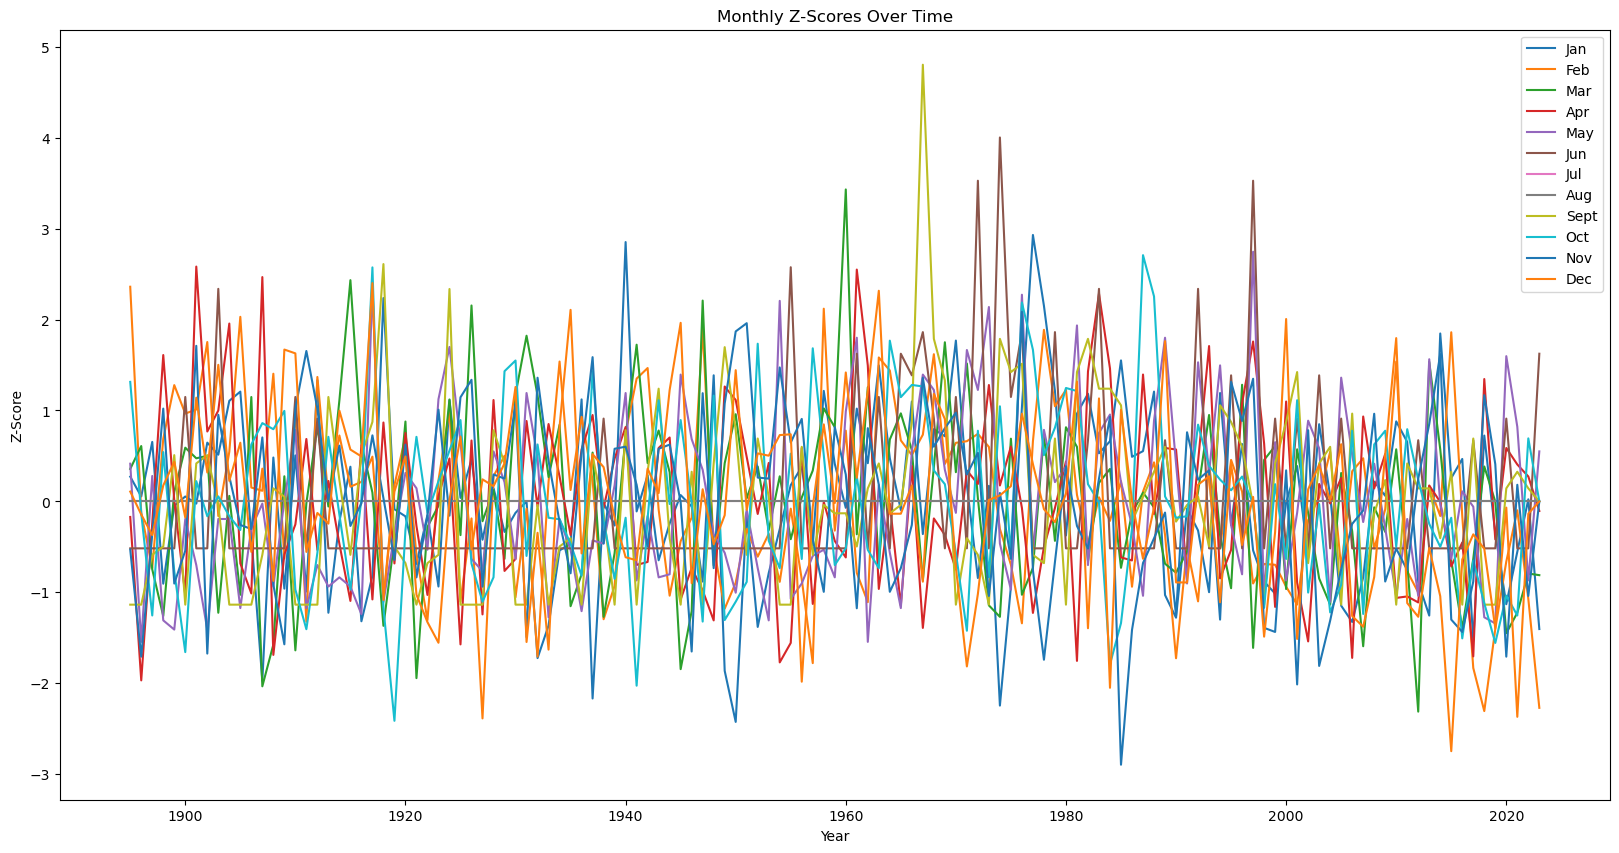

In [8]:
def plot_monthly_z_scores(df):
    """Will plot monthly z_scores on one graph given the proper dataframe"""
    plt.figure(figsize=(20, 10))
    # Assuming the exact names of the months are as listed and 'year' is correctly named
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec']
    for month in months:
        plt.plot(df['year'], df[month], label = month.capitalize())
    plt.xlabel('Year')
    plt.ylabel('Z-Score')
    plt.title('Monthly Z-Scores Over Time')
    plt.legend()
    plt.show()

plot_monthly_z_scores(heater_z)

### Building Training and Valid Data

In [10]:
def prep_time_series(df, value_name = 'value'):
    """Use this function to transform to a time series with a single column"""
    df_long = df.melt(id_vars=['year'], var_name='month', value_name=value_name) # melt to distribute the values to long format
    month_to_num = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                    'jul': 7, 'aug': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    df_long['month'] = df_long['month'].map(month_to_num) # map each to numbers
    df_long['date'] = pd.to_datetime(df_long[['year', 'month']].assign(DAY=1))
    df_long = df_long.sort_values('date')
    df_long.set_index('date', inplace=True)
    df_long.drop(['year', 'month'], axis=1, inplace=True)
    return df_long

heater_z_prep = prep_time_series(heater_z, "z-score")
heater_z_prep.head()

z-score
date                
1895-01-01  0.272147
1895-02-01  2.360247
1895-03-01  0.357166
1895-04-01 -0.170976
1895-05-01  0.414753

In [11]:
# divide the data into two separate sets
Train = heater_z_prep[heater_z_prep.index.year < 1980].reset_index()
Valid = heater_z_prep[heater_z_prep.index.year >= 1980].reset_index()
print(Train.columns)

Index(['date', 'z-score'], dtype='object')


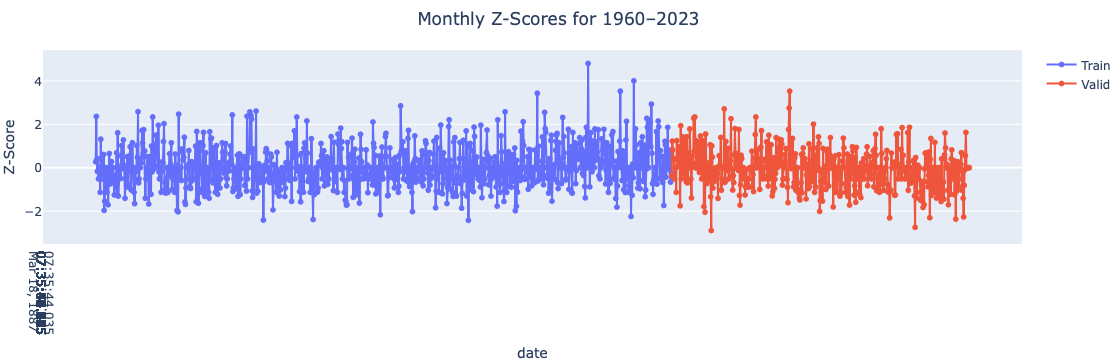

In [12]:
# visualize data as training and valid data for further downstream analysis
fig = go.Figure()
fig.add_trace(go.Scatter(x=Train['date'], y=Train['z-score'], mode='lines+markers', name='Train'))
fig.add_trace(go.Scatter(x=Valid['date'], y=Valid['z-score'], mode='lines+markers', name='Valid'))

fig.update_layout(title_text="Monthly Z-Scores for 1960–2023", title_x=0.5,
                  margin=dict(l=10, r=0, t=50, b=50),
                  xaxis_title_text="date",
                  xaxis=dict(tickmode='linear', tick0=1895, dtick=10),
                  yaxis_title_text="Z-Score")

fig.show()

### Seasonal Decomposition of climate data heating days

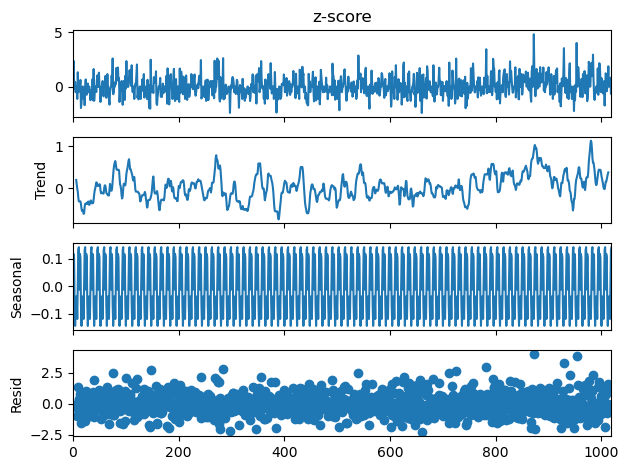

In [26]:
result = seasonal_decompose(Train['z-score'], model='additive', period=12)
result.plot()
plt.show()

### Building the SARIMA model

In [67]:
sari_cool_raw = pd.DataFrame(cool[["year", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sept", "oct", "nov", "dec"]])

def prep_time_series(df, value_name = 'value'):
    df_long = df.melt(id_vars=['year'], var_name='month', value_name=value_name) # melt to distribute the values to long format
    month_to_num = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                    'jul': 7, 'aug': 8, 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    df_long['month'] = df_long['month'].map(month_to_num) # map each to numbers
    df_long['date'] = pd.to_datetime(df_long[['year', 'month']].assign(DAY=1))
    df_long = df_long.sort_values('date')
    df_long.set_index('date', inplace=True)
    df_long.drop(['year', 'month'], axis=1, inplace=True)
    return df_long

sari_cool_raw_2 = prep_time_series(sari_cool_raw, value_name='cooling_days')
sari_cool_raw_2

cooling_days
date                    
1895-01-01           0.0
1895-02-01           0.0
1895-03-01           6.0
1895-04-01          15.0
1895-05-01          99.0
...                  ...
2023-08-01           NaN
2023-09-01           NaN
2023-10-01           NaN
2023-11-01           NaN
2023-12-01           NaN

[1548 rows x 1 columns]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14662D+00    |proj g|=  8.08174D-02


 This problem is unconstrained.



At iterate    5    f=  5.08240D+00    |proj g|=  2.18976D-02

At iterate   10    f=  4.97707D+00    |proj g|=  8.44414D-02

At iterate   15    f=  4.97272D+00    |proj g|=  2.01961D-04

At iterate   20    f=  4.97134D+00    |proj g|=  2.45064D-02

At iterate   25    f=  4.96832D+00    |proj g|=  5.22280D-04

At iterate   30    f=  4.96832D+00    |proj g|=  3.86662D-04

At iterate   35    f=  4.96130D+00    |proj g|=  3.53818D-02

At iterate   40    f=  4.95946D+00    |proj g|=  1.65937D-03

At iterate   45    f=  4.95945D+00    |proj g|=  4.19043D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     71   

<Axes: >

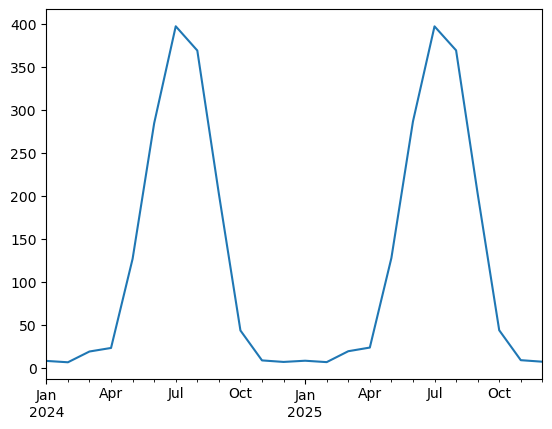

In [69]:
time_series = sari_cool_raw_2['cooling_days']
time_series.index.freq = 'MS'
# Initialize and fit the SARIMAX model
# Note: Choose the order and seasonal_order based on your data's characteristics
model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Summary of the model fit
print(model_fit.summary())

# Make predictions or forecasts
forecast = model_fit.forecast(steps=24)
forecast.plot()